In [1]:
import mne
import pickle

In [2]:
ALSdata = 'C:/Users/salta/Documents/2nd year masters/BMI/ALSdata.pickle'
BNCIdata = 'C:/Users/salta/Documents/2nd year masters/BMI/BNCI2015003.pickle'
TenHealthydata = 'C:/Users/salta/Documents/2nd year masters/BMI/TenHealthyData.pickle'
data_allsubjects = 'C:/Users/salta/Documents/2nd year masters/BMI/data_allsubjects.pickle'
EPFLdata  = 'C:/Users/salta/Documents/2nd year masters/BMI/EPFLP300.pickle'

In [3]:
def loaddata(filename):
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [4]:
ALS = loaddata(ALSdata)
BNCI = loaddata(BNCIdata)
Ten = loaddata(TenHealthydata)
allsubjects = loaddata(data_allsubjects)
EPFL = loaddata(EPFLdata)

In [5]:
## NUMBER OF EPOCHS FOR EACH DATASET
print(len(ALS))
print(len(BNCI))
print(len(EPFL))
print(len(Ten))
print(len(allsubjects))

8
10
8
10
16


In [6]:
## DIMENSIONS FOR EACH SUBJECT IN DATASET
print('ALS data = ', ALS[0].get_data().shape)
print('BNCI data = ', BNCI[0].get_data().shape)
print('EPFL data = ', EPFL[0].get_data().shape)
print('Ten healthy data = ', Ten[0].get_data().shape)
print('All subjects data = ',allsubjects[0].get_data().shape)

ALS data =  (4200, 8, 78)
BNCI data =  (5400, 8, 128)
EPFL data =  (3342, 32, 77)
Ten healthy data =  (1728, 16, 78)
All subjects data =  (3982, 16, 76)


In [7]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from mne.decoding import Vectorizer
from sklearn import preprocessing
import numpy as np

In [8]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline, Pipeline

In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [74]:
def random_forest_clf(subject1):
    
    epochs= subject1.pick_types(eeg=True)
    X = epochs.get_data()  

    y = epochs.events[:, -1] 
    nsamples, nx, ny = X.shape
    X = X.reshape((nsamples,nx*ny))

    X = preprocessing.normalize(X, norm='l2')
     
    train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=123)
    
    
    new_clf = make_pipeline(Vectorizer(),StandardScaler(), 
                            RandomForestClassifier())
    new_clf.fit(train_X, train_y)
    pred_y = new_clf.predict(test_X)
    #print("Fraction Correct [Accuracy]", i+1, ':')
    acc = np.sum(pred_y == test_y) / float(len(test_y))
    #print(np.sum(pred_y == test_y) / float(len(test_y)))
    return acc
    
    

In [90]:
from sklearn.ensemble import ExtraTreesClassifier
def logreg400(subject1):
    
    epochs= subject1.pick_types(eeg=True)
    X = epochs.get_data()  
# features
    y = epochs.events[:, -1] 
    nsamples, nx, ny = X.shape
    X = X.reshape((nsamples,nx*ny))
    
    X = preprocessing.normalize(X, norm='l2')

     
    train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=123)
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train_X, train_y)
    extree = ExtraTreesClassifier(n_estimators=50)
    
    
    new_clf = make_pipeline(Vectorizer(),StandardScaler(), SelectFromModel(extree, prefit=False),
                            LogisticRegression(solver='lbfgs',max_iter =400))
    ## If there will be warning about convergence during EPFL training, set the max_iter =1000
    
    #new_clf = make_pipeline(Vectorizer(),StandardScaler(), SelectFromModel(extree, prefit=False),
                            #LogisticRegression(solver='lbfgs',max_iter =1000))
        
    
    new_clf.fit(train_X, train_y)
    pred_y = new_clf.predict(test_X)
    #print("Fraction Correct [Accuracy]", i+1, ':')
    acc  = np.sum(pred_y == test_y) / float(len(test_y))
    #print(np.sum(pred_y == test_y) / float(len(test_y)))
    return acc

In [34]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.svm import SVC
def svm_clf(subject1):
    acc= []
    epochs= subject1.pick_types(eeg=True)
    X = epochs.get_data()  
# features
    y = epochs.events[:, -1] 
    nsamples, nx, ny = X.shape
    X = X.reshape((nsamples,nx*ny))
    #train_X = train_X.astype('float32')
    #test_X = test_X.astype('float32')
    scaler = preprocessing.StandardScaler().fit(X)

#StandardScaler()



    X = scaler.transform(X)

     
    train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=123)
    
    


    
    
    new_clf = make_pipeline(Vectorizer(),StandardScaler(), 
                            SVC())
    new_clf.fit(train_X, train_y)
    pred_y = new_clf.predict(test_X)
    #print("Fraction Correct [Accuracy]", i+1, ':')
    acc = np.sum(pred_y == test_y) / float(len(test_y))
    
    #print(np.sum(pred_y == test_y) / float(len(test_y)))
    return acc

In [92]:
## This function get the all accuracies from each subject and computes average for whole dataset.

def average_acc(alls, svm_clf):
    acc = []
    total = 0 

    for i in range(len(alls)):
        end = svm_clf(alls[i])
        acc.append(end)
        total+=acc[i]
    print(acc)
    
    return total/len(alls)
    

In [51]:
## All subjects data was trained on Log reg with 400 max iterations
## Data was scaled using Standard Scaler and reshaped to 2D. Extra Tree feature selection method was done.
average_acc(allsubjects, logreg400)

[0.8624497991967871, 0.891726251276813, 0.8754863813229572, 0.8833640270104358, 0.8963486454652533, 0.8812877263581489, 0.9037800687285223, 0.8707482993197279, 0.8666666666666667, 0.8517786561264822, 0.8689655172413793, 0.8623402163225172, 0.8991185112634672, 0.885685884691849, 0.8904593639575972, 0.8866736621196223]


0.8798049798167642

In [75]:
## All subjects dataset was trained on Random Forest classifier (no Feature selection)
## Data was scaled using Standard Scaler and reshaped to 2D.
average_acc(allsubjects, random_forest_clf)

[0.8704819277108434, 0.8682328907048008, 0.8560311284046692, 0.8655616942909761, 0.8798586572438163, 0.8702213279678068, 0.8694158075601375, 0.8639455782312925, 0.8589371980676328, 0.8606719367588933, 0.8453201970443349, 0.8613569321533924, 0.8736532810969637, 0.8578528827037774, 0.8798586572438163, 0.838405036726128]


0.8637378208693302

In [76]:
## All subjects dataset was trained on SVM classifier ( no Feature selection)
## Data was scaled using Standard Scaler and reshaped to 2D.
average_acc(allsubjects, svm_clf)

[0.8704819277108434, 0.874361593462717, 0.8560311284046692, 0.8784530386740331, 0.9069493521790342, 0.8822937625754527, 0.8865979381443299, 0.8639455782312925, 0.8599033816425121, 0.8606719367588933, 0.8463054187192118, 0.8613569321533924, 0.8844270323212536, 0.8628230616302187, 0.8886925795053003, 0.85099685204617]


0.8708932196349577

In [44]:
## Ten Healthy dataset was trained on SVM (No feature selection)
average_acc(Ten, svm_clf)

[0.8587962962962963, 0.8703703703703703, 0.8657407407407407, 0.8865740740740741, 0.8865740740740741, 0.8263888888888888, 0.8240740740740741, 0.8356481481481481, 0.9050925925925926, 0.9120370370370371]


0.8671296296296296

In [78]:
## Ten Healthy with Logistic Regression, Extra Tree
average_acc(Ten, logreg400)

[0.9120370370370371, 0.9351851851851852, 0.8634259259259259, 0.9143518518518519, 0.8912037037037037, 0.8865740740740741, 0.8865740740740741, 0.8842592592592593, 0.9421296296296297, 0.9143518518518519]


0.9030092592592593

In [80]:
## Ten healthy dataset with Random Forest
average_acc(Ten, random_forest_clf)

[0.8472222222222222, 0.8518518518518519, 0.8356481481481481, 0.8657407407407407, 0.8587962962962963, 0.8310185185185185, 0.8287037037037037, 0.8356481481481481, 0.8912037037037037, 0.8796296296296297]


0.8525462962962962

In [81]:
## BNCI with Random Forest 
## The accuracies are for 10 subjects presented in BNCI
average_acc(BNCI, random_forest_clf)

[0.9792592592592593, 0.9748148148148148, 0.8377777777777777, 0.8066666666666666, 0.8288888888888889, 0.8577777777777778, 0.8244444444444444, 0.8288888888888889, 0.8555555555555555, 0.8622222222222222]


0.8656296296296295

In [82]:
## BNCI dataset was trained on SVM
average_acc(BNCI, svm_clf)

[0.9792592592592593, 0.9748148148148148, 0.8355555555555556, 0.8088888888888889, 0.8333333333333334, 0.8577777777777778, 0.8244444444444444, 0.8311111111111111, 0.8555555555555555, 0.8688888888888889]


0.866962962962963

In [83]:
## BNCI was trained on Logistic Regression, max_iter =400, extra tree feature selection
average_acc(BNCI, logreg400)

[0.9688888888888889, 0.9740740740740741, 0.8222222222222222, 0.8333333333333334, 0.8266666666666667, 0.7688888888888888, 0.8022222222222222, 0.8577777777777778, 0.8666666666666667, 0.88]


0.8600740740740742

In [91]:
## EPFL with Logistic Regression, max_iter =1000, extra tree classifier was used
average_acc(EPFL, logreg400)

[0.8433014354066986, 0.8231046931407943, 0.8552631578947368, 0.8554216867469879, 0.8424242424242424, 0.8600237247924081, 0.9232613908872902, 0.8440145102781137]


0.855851855196409

In [85]:
## EPFL with SVM 
average_acc(EPFL, svm_clf)

[0.8397129186602871, 0.8134777376654633, 0.8421052631578947, 0.8313253012048193, 0.8363636363636363, 0.8362989323843416, 0.8321342925659473, 0.8295042321644498]


0.8326152892708549

In [86]:
## EPFL with Random Forest
average_acc(EPFL, random_forest_clf)

[0.8720095693779905, 0.8170878459687124, 0.8648325358851675, 0.827710843373494, 0.8569696969696969, 0.8469750889679716, 0.8609112709832134, 0.8282950423216445]


0.8468489867309863

In [87]:
## ALS with Logistic Regression, max_iter =400, extra tree was used for Feature selection
average_acc(ALS, logreg400)

[0.8438095238095238, 0.8476190476190476, 0.8790476190476191, 0.8580952380952381, 0.8428571428571429, 0.8809523809523809, 0.8790476190476191, 0.8942857142857142]


0.8657142857142857

In [88]:
## ALS with SVM
average_acc(ALS, svm_clf)

[0.8247619047619048, 0.8542857142857143, 0.8295238095238096, 0.8257142857142857, 0.8342857142857143, 0.8428571428571429, 0.8533333333333334, 0.8838095238095238]


0.8435714285714286

In [89]:
## ALS dataset was trained on random forest, 8 subjects. 
average_acc(ALS, random_forest_clf)

[0.8238095238095238, 0.8590476190476191, 0.8247619047619048, 0.8266666666666667, 0.8304761904761905, 0.8285714285714286, 0.8590476190476191, 0.8371428571428572]


0.8361904761904762

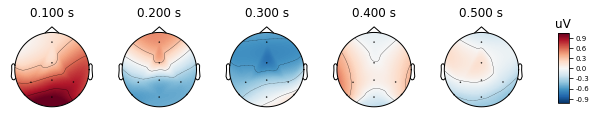

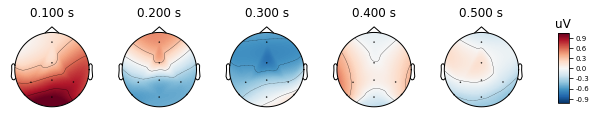

In [98]:
## Visualization
als = ALS[0]
nontarget =  als['NonTarget'].average()
nontarget.plot_topomap(times = [0.1, 0.2, 0.3, 0.4, 0.5])

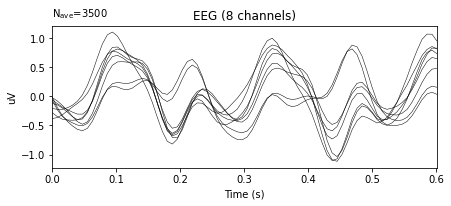

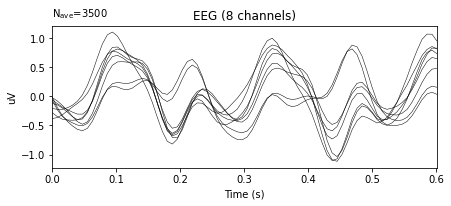

In [99]:
nontarget.plot()

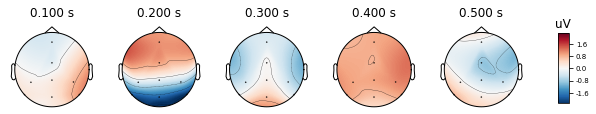

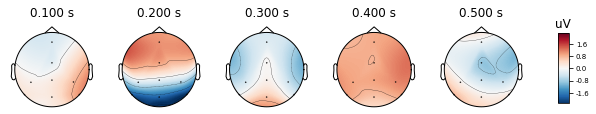

In [100]:
target =  als['Target'].average()
target.plot_topomap(times = [0.1, 0.2, 0.3, 0.4, 0.5])

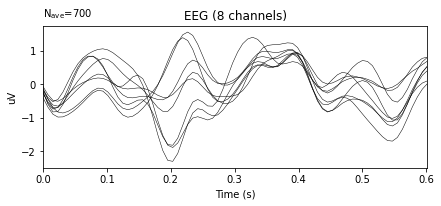

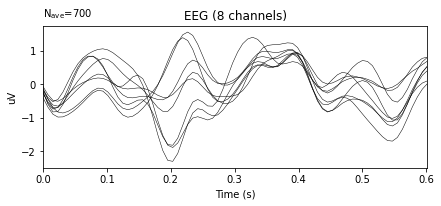

In [101]:
target.plot()